# Section 1. Data Preprocessing & Cleaning

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os 
import sys
import datetime as DT

os.chdir(r'C:\Users\Asus\Documents\Holmusk data\datasciencepositionatholmusk')
bill_amount = pd.read_csv('bill_amount.csv')
bill_id = pd.read_csv('bill_id.csv')
clinical_data = pd.read_csv('clinical_data.csv')
demo = pd.read_csv('demographics.csv')

In [2]:
#convert to lowercase for ease of application
demo.gender = demo.gender.apply(lambda x: x.lower())

In [3]:
demo.race = demo.race.apply(lambda x: x.lower())

In [4]:
demo.resident_status = demo.resident_status.apply(lambda x: x.lower())

In [5]:
#Identifying errant/abnormal inputs for categorical variables within the demographics spreadsheet
demo.gender.value_counts()

female    1396
male      1333
m          170
f          101
Name: gender, dtype: int64

In [6]:
demo.race.value_counts()

chinese    1915
malay       629
indian      195
others      161
india       100
Name: race, dtype: int64

In [7]:
demo.resident_status.value_counts()

singaporean          1782
singapore citizen     610
pr                    465
foreigner             143
Name: resident_status, dtype: int64

In [8]:
#Standardising male & female categorical variables to 'male' and 'female'
demo.gender = demo.gender.apply(lambda x: 'male' if x == 'm' else('female' if x == 'f' else (x)))

In [9]:
#Standardising 'indian' category for race 
demo.race = demo.race.apply(lambda x: 'indian' if x == 'india' else(x))

In [10]:
#Standardising 'singaporean' category for resident status because singapore citizens are singaporeans
demo.resident_status = demo.resident_status.apply(lambda x: 'singaporean' if x == 'singapore citizen' else(x))

In [11]:
demo = demo.set_index('patient_id')

# Checking for correlation and potential multicollinearity 

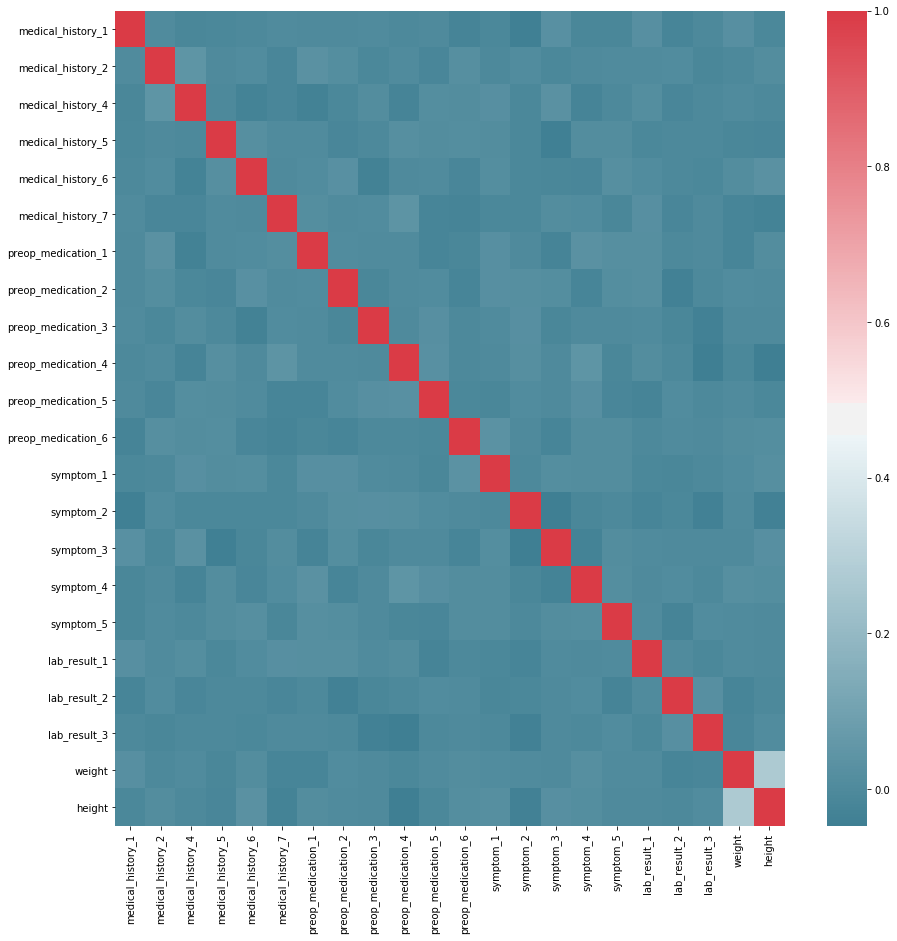

In [79]:
f, ax = plt.subplots(figsize=(15, 15))
corr_cd = clinical_data.corr()
sns.heatmap(corr_cd,mask=np.zeros_like(corr_cd, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax = ax)

From a visual analysis of the correlation heatmap, none of the variables exhibit potential collinearity except for weight and height. 

In [80]:
clinical_data = clinical_data.sort_values(['id', 'date_of_admission'])

In [14]:
#Removing duplicated patient id samples from the spreadsheet to simplify the analysis 
cd_dup = clinical_data[[not i for i in clinical_data.duplicated(subset = ['id'])]]

In [15]:
#Handling NaN values. From visual data observation, the NaN values were from the medical history variables, which are binary in nature. 
cd_dup = cd_dup.fillna(value = 0)

In [16]:
cd_dup.medical_history_3 = cd_dup.medical_history_3.apply(lambda x: x if type(x) == int else (1 if x == 'Yes' else (0)))

In [17]:
cd_dup.medical_history_2 = cd_dup.medical_history_2.astype('int64')
cd_dup.medical_history_5 = cd_dup.medical_history_5.astype('int64')

Feature engineering for the given dataset. The inpatient duration is potentially more relevant than the dates of admission & discharge themselves. As such, we engineer a new feature, inpatient duration, which would be the difference in days between discharge & admission.

In [18]:
cd_dup.date_of_admission = cd_dup.date_of_admission.astype('datetime64')
cd_dup.date_of_discharge = cd_dup.date_of_discharge.astype('datetime64')

In [19]:
cd_dup['inpatient_D'] = (cd_dup.date_of_discharge - cd_dup.date_of_admission).dt.days

In [20]:
cd_dup['BMI'] = (cd_dup.weight/(cd_dup.height*cd_dup.height) * 10000)

In [21]:
cd_dup['N_Hist'] = cd_dup.medical_history_1 + cd_dup.medical_history_2 + cd_dup.medical_history_3 + cd_dup.medical_history_4 + cd_dup.medical_history_5 + cd_dup.medical_history_6 + cd_dup.medical_history_7  

In [22]:
cd_dup['N_Med'] = cd_dup.preop_medication_1 + cd_dup.preop_medication_2 + cd_dup.preop_medication_3 + cd_dup.preop_medication_4 + cd_dup.preop_medication_5 

In [23]:
cd_dup['N_Symp'] = cd_dup.symptom_1 + cd_dup.symptom_2 + cd_dup.symptom_3 + cd_dup.symptom_4 + cd_dup.symptom_5 

In [24]:
cd_dup = cd_dup.drop(['date_of_discharge', 'weight', 'height'], axis =1)

In [25]:
cd_dup = cd_dup.set_index('id')

In [26]:
joined = cd_dup.merge(demo, left_index = True, right_index = True)

In [30]:
#From the given date of birth, we can calculate their age 
joined.date_of_birth = joined.date_of_birth.astype('datetime64')
joined.date_of_admission = joined.date_of_admission.astype('datetime64')

In [31]:
joined['age'] = joined.date_of_admission.dt.year - joined.date_of_birth.dt.year

In [32]:
joined = joined.drop('date_of_birth', axis =1)

In [119]:
bill_id['patient_id'] = bill_id.patient_id.astype(str)

In [34]:
bill = pd.merge(bill_id, bill_amount, on = 'bill_id')

In [35]:
bill = bill.drop('bill_id', axis =1 )

In [36]:
#Summing up bills from the 4 separate bill_id for each patient_id and date_of_admission
bg = bill.groupby(['patient_id', 'date_of_admission']).amount.sum()

In [37]:
bg_ri = bg.reset_index()

In [38]:
#Simplifying the model by taking only the first admission for each patient _id
bg_first = bg_ri[[not i for i in bg_ri.duplicated(subset = 'patient_id')]]

In [39]:
bg_first = bg_first.set_index('patient_id')

In [40]:
#merge the joined dataset(which merges clinical_data & demographics) and the bg_first dataset(which merges bill_amount & bill_id)
merged = joined.merge(bg_first, left_index = True, right_index = True)

In [41]:
merged = merged.drop(['date_of_admission_x', 'date_of_admission_y'], axis = 1)

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


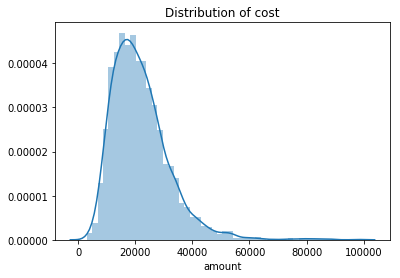

In [42]:
distPlot = sns.distplot(merged['amount'])
plt.title("Distribution of cost")
plt.show()

In [43]:
merged.amount.describe()
#NOTE: Handle outlier cases (max) & assess for need to do log transformation

count     3000.000000
mean     21798.335703
std      10161.000119
min       2946.100354
25%      14665.890997
50%      20101.522184
75%      26733.192619
max      98120.870207
Name: amount, dtype: float64

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


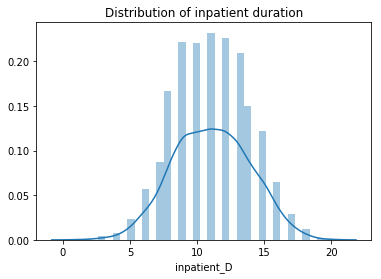

In [44]:
distPlot_inD = sns.distplot(merged['inpatient_D'])
plt.title("Distribution of inpatient duration")
plt.show()

In [45]:
merged.inpatient_D.describe()

count    3000.000000
mean       11.078667
std         2.855497
min         1.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        20.000000
Name: inpatient_D, dtype: float64

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


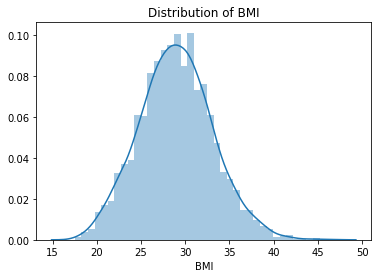

In [46]:
distPlot_bmi = sns.distplot(merged['BMI'])
plt.title("Distribution of BMI")
plt.show()

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


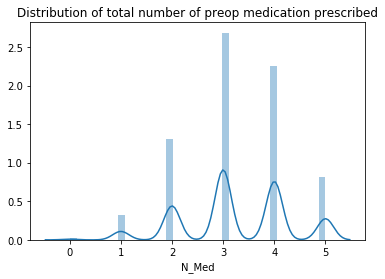

In [47]:
distPlot_N_med = sns.distplot(merged['N_Med'])
plt.title("Distribution of total number of pre-op medication prescribed")
plt.show()

From the countplots obtained for all the preop_medications, we can observe that preop_medication_3 and preop_medication_5 are prescribed to patients more frequently than the rest. These two medications could be common medications. 

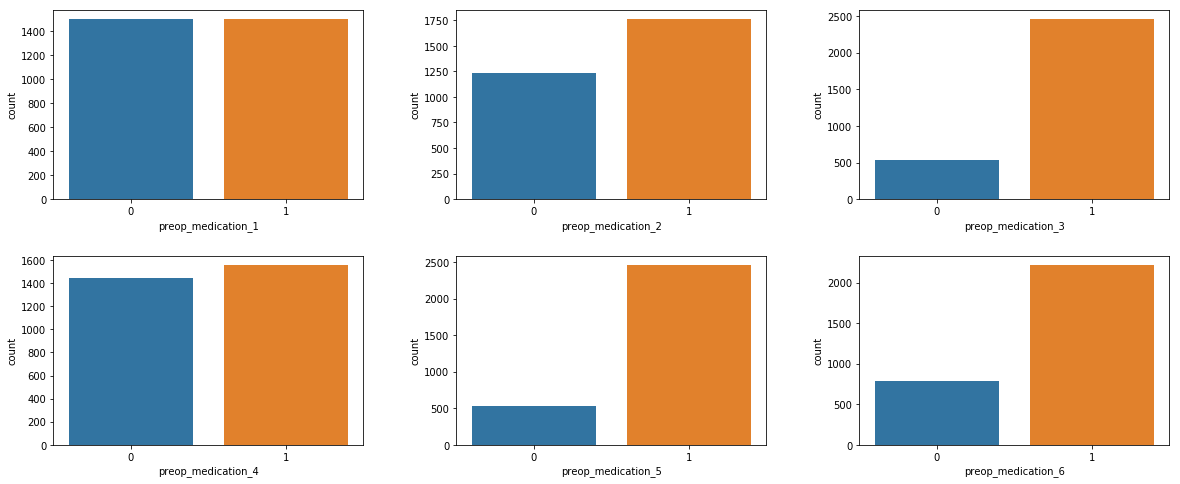

In [121]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.countplot(merged["preop_medication_1"],  ax = ax1)
sns.countplot(merged["preop_medication_2"],  ax = ax2)
sns.countplot(merged["preop_medication_3"],  ax = ax3)
sns.countplot(merged["preop_medication_4"],  ax = ax4)
sns.countplot(merged["preop_medication_5"],  ax = ax5)
sns.countplot(merged["preop_medication_6"],  ax = ax6)

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


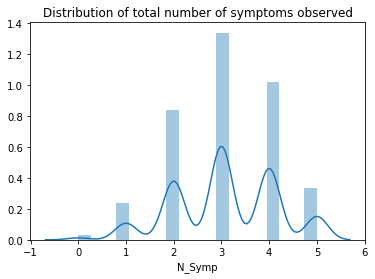

In [48]:
distPlot_N_Symp = sns.distplot(merged['N_Symp'])
plt.title("Distribution of total number of symptoms observed")
plt.show()

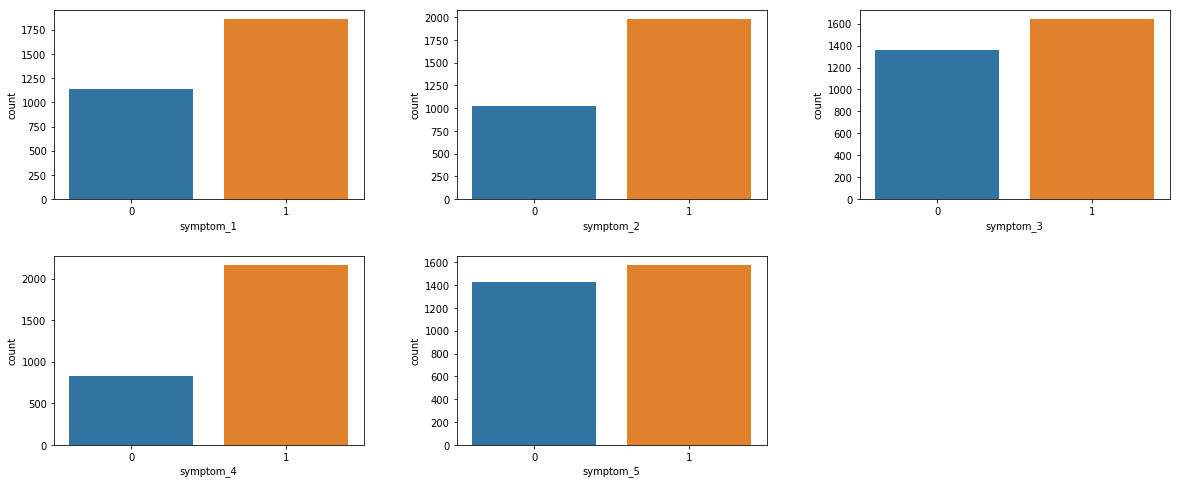

In [122]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.countplot(merged["symptom_1"],  ax = ax1)
sns.countplot(merged["symptom_2"],  ax = ax2)
sns.countplot(merged["symptom_3"],  ax = ax3)
sns.countplot(merged["symptom_4"],  ax = ax4)
sns.countplot(merged["symptom_5"],  ax = ax5)

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


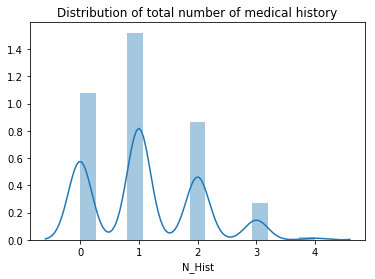

In [49]:
distPlot_N_Hist = sns.distplot(merged['N_Hist'])
plt.title("Distribution of total number of medical history")
plt.show()

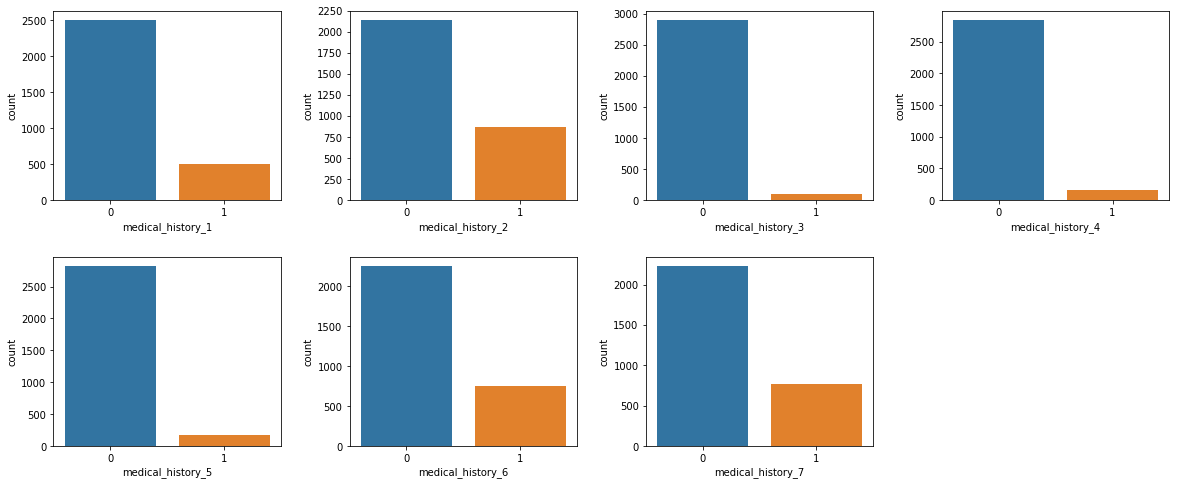

In [117]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 4), (0, 0))
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (0, 2))
ax4 = plt.subplot2grid((2, 4), (0, 3))
ax5 = plt.subplot2grid((2, 4), (1, 0))
ax6 = plt.subplot2grid((2, 4), (1, 1))
ax7 = plt.subplot2grid((2, 4), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.countplot(merged["medical_history_1"],  ax = ax1)
sns.countplot(merged["medical_history_2"],  ax = ax2)
sns.countplot(merged["medical_history_3"],  ax = ax3)
sns.countplot(merged["medical_history_4"],  ax = ax4)
sns.countplot(merged["medical_history_5"],  ax = ax5)
sns.countplot(merged["medical_history_6"],  ax = ax6)
sns.countplot(merged["medical_history_7"],  ax = ax7)

In [50]:
merged.BMI.describe()

count    3000.000000
mean       28.955222
std         4.144775
min        17.508651
25%        26.161927
50%        28.921908
75%        31.675212
max        46.677349
Name: BMI, dtype: float64

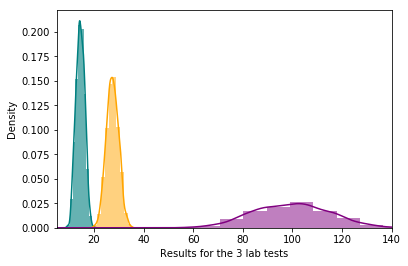

In [51]:
ax = merged['lab_result_1'].hist(density=True, stacked=True, color='teal', alpha=0.6)
merged['lab_result_1'].plot(kind='density', color='teal')
ax = merged['lab_result_2'].hist(density=True, stacked=True, color='orange', alpha=0.5)
merged['lab_result_2'].plot(kind='density', color='orange')
ax = merged['lab_result_3'].hist(density=True, stacked=True, color='purple', alpha=0.5)
merged['lab_result_3'].plot(kind='density', color='purple')
ax.set(xlabel='Results for the 3 lab tests')
plt.xlim(5, 140)
plt.show()
#Most likely the 3 tests are different

In [52]:
#Normalization of numerical columns. Not done on categorical variables for variable inference 
#Choose samples which lie within 3 standard deviations from the mean of normalized variables to preserve sample numbers 
import scipy as sp

numerical_columns = ['amount', 'inpatient_D', 'BMI', 'lab_result_1', 'lab_result_2', 'lab_result_3']
merged_normed = merged[(np.abs(sp.stats.zscore(merged[numerical_columns])) < 3).all(axis=1)]

In [53]:
merged_normed.describe()

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,...,lab_result_1,lab_result_2,lab_result_3,inpatient_D,BMI,N_Hist,N_Med,N_Symp,age,amount
count,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,...,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000
mean,0.162862,0.287564,0.034753,0.052129,0.058944,0.247359,0.256218,0.500170,0.587734,0.818399,...,14.483816,27.442624,99.617036,11.081090,28.887756,1.099830,3.246678,3.062351,52.240886,21232.128352
std,0.369303,0.452704,0.183185,0.222326,0.235560,0.431551,0.436618,0.500085,0.492326,0.385581,...,1.745219,2.452304,15.119199,2.832323,4.070715,0.916365,1.030781,1.073570,14.600365,8826.831861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.400000,20.100000,57.000000,3.000000,17.508651,0.000000,0.000000,0.000000,22.000000,2946.100354
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,13.200000,25.800000,88.000000,9.000000,26.154824,0.000000,3.000000,2.000000,39.000000,14579.626555
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,14.500000,27.400000,100.000000,11.000000,28.870523,1.000000,3.000000,3.000000,50.000000,19933.214177
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,15.800000,29.200000,110.000000,13.000000,31.601591,2.000000,4.000000,4.000000,65.000000,26479.242239
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.300000,34.500000,143.000000,19.000000,40.945291,4.000000,5.000000,5.000000,85.000000,52224.523780


C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


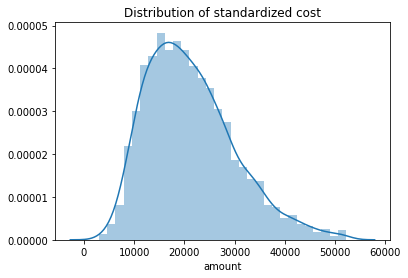

In [54]:
distPlot_cost_normed = sns.distplot(merged_normed['amount'])
plt.title("Distribution of standardized cost")
plt.show()

In [55]:
merged_normed.skew()

medical_history_1     1.827054
medical_history_2     0.939161
medical_history_3     5.083003
medical_history_4     4.031701
medical_history_5     3.747306
medical_history_6     1.171648
medical_history_7     1.117444
preop_medication_1   -0.000682
preop_medication_2   -0.356650
preop_medication_3   -1.652651
preop_medication_4   -0.078465
preop_medication_5   -1.673636
preop_medication_6   -1.091033
symptom_1            -0.481766
symptom_2            -0.661323
symptom_3            -0.180032
symptom_4            -0.993312
symptom_5            -0.085300
lab_result_1         -0.022742
lab_result_2         -0.004279
lab_result_3          0.016645
inpatient_D           0.018023
BMI                   0.079351
N_Hist                0.516904
N_Med                -0.237621
N_Symp               -0.168761
age                   0.250304
amount                0.749955
dtype: float64

In [118]:
merged_normed.kurtosis()

medical_history_1      1.339037
medical_history_2     -1.118739
medical_history_3     23.853174
medical_history_4     14.264335
medical_history_5     12.050516
medical_history_6     -0.627670
medical_history_7     -0.751831
preop_medication_1    -2.001364
preop_medication_2    -1.874078
preop_medication_3     0.731755
preop_medication_4    -1.995203
preop_medication_5     0.801604
preop_medication_6    -0.810200
symptom_1             -1.769107
symptom_2             -1.563718
symptom_3             -1.968931
symptom_4             -1.014022
symptom_5             -1.994083
lab_result_1          -0.489897
lab_result_2          -0.286485
lab_result_3          -0.367245
inpatient_D           -0.419862
BMI                   -0.156512
N_Hist                -0.354818
N_Med                 -0.259810
N_Symp                -0.337746
age                   -1.113312
amount                 0.381825
dtype: float64

# Gender vs Cost 

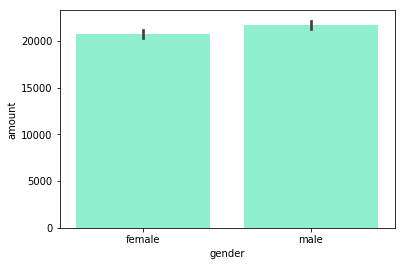

In [56]:
sns.barplot('gender', 'amount', data=merged_normed, color="aquamarine")

# Race vs Cost  

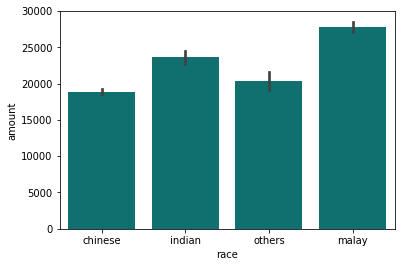

In [57]:
sns.barplot('race', 'amount', data=merged_normed, color="teal")


# Resident Status vs Cost

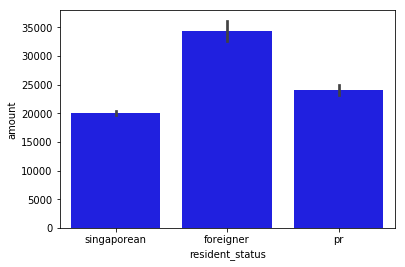

In [58]:
sns.barplot('resident_status', 'amount', data=merged_normed, color="blue")

# Inpatient Duration vs Cost

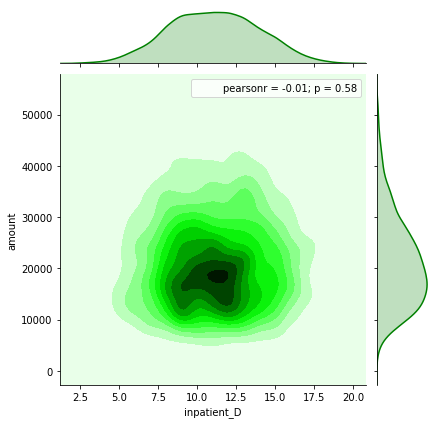

In [59]:
sns.jointplot('inpatient_D', 'amount', data=merged_normed, kind = 'kde', color="g")

# BMI vs Cost

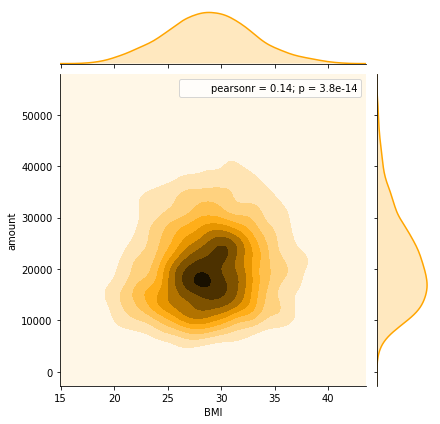

In [60]:
sns.jointplot('BMI', 'amount', data=merged_normed, kind = 'kde',  color="orange")

# Age vs Cost

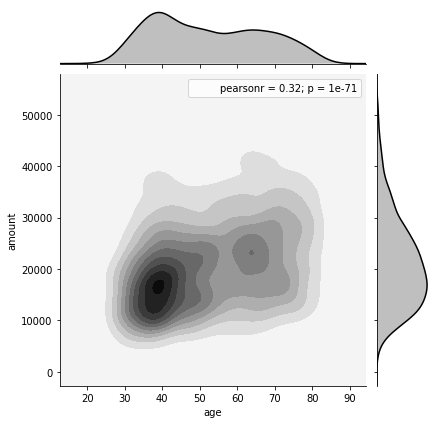

In [61]:
sns.jointplot('age', 'amount', data=merged_normed, kind = 'kde', color="k")

# Medical History Availability vs Cost

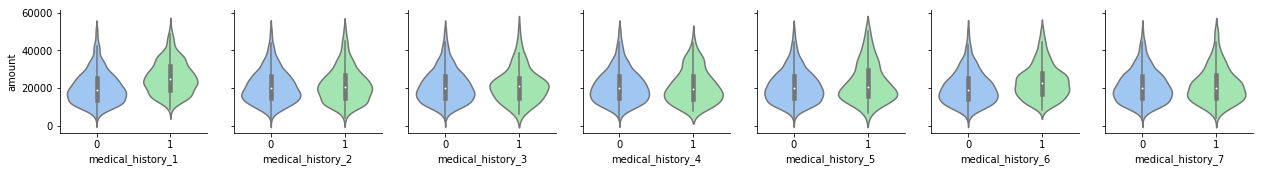

In [62]:
g = sns.PairGrid(x_vars=["medical_history_1", "medical_history_2", "medical_history_3", "medical_history_4", "medical_history_5",
                        "medical_history_6", "medical_history_7"],
                 y_vars=["amount"], data = merged_normed)
g.map(sns.violinplot, palette="pastel")

# Symptom presence vs Cost

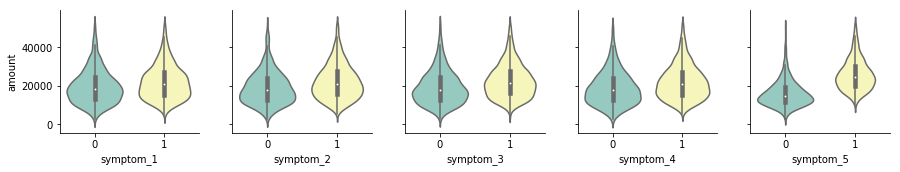

In [63]:
g = sns.PairGrid(x_vars=["symptom_1", "symptom_2", "symptom_3", "symptom_4", "symptom_5"], 
                 y_vars=["amount"], data = merged_normed)
g.map(sns.violinplot, palette="Set3")

# Pre-op medication type prescription vs Cost

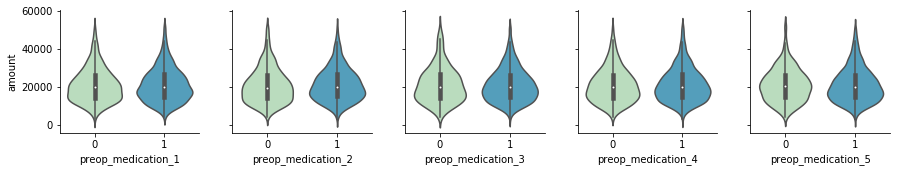

In [64]:
g = sns.PairGrid(x_vars=["preop_medication_1", "preop_medication_2", "preop_medication_3", "preop_medication_4", "preop_medication_5"], 
                 y_vars=["amount"], data = merged_normed)
g.map(sns.violinplot, palette="GnBu")

# Number of pre-op medication prescribed vs cost

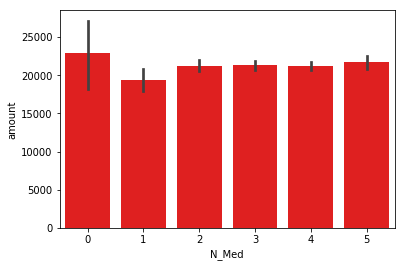

In [65]:
sns.barplot('N_Med', 'amount', data=merged_normed, color="red")

# Total number of symptoms present vs cost 

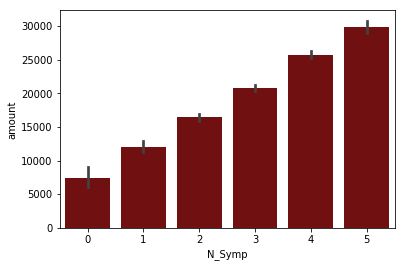

In [66]:
sns.barplot('N_Symp', 'amount', data=merged_normed, color="maroon")

# Total number of medical history present vs cost

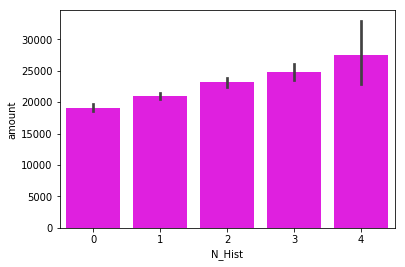

In [67]:
sns.barplot('N_Hist', 'amount', data=merged_normed, color="magenta")

In [69]:
Data = merged.reset_index().drop('index', axis =1)

In [70]:
to_encode = ['gender', 'race', 'resident_status']
Data_encoded = pd.get_dummies(Data, columns = to_encode)

In [82]:
numer_list = ['inpatient_D', 'BMI', 'N_Hist', 'N_Symp', 'age', 'lab_result_1', 'lab_result_2', 'lab_result_3']

for key in numer_list: 
    col_mean = np.mean(Data_encoded[key])
    col_stdev = np.std(Data_encoded[key])
    Data_encoded[key] = Data_encoded[key].apply(lambda x: ((x - col_mean)/col_stdev))

# Correlation of variables against cost 


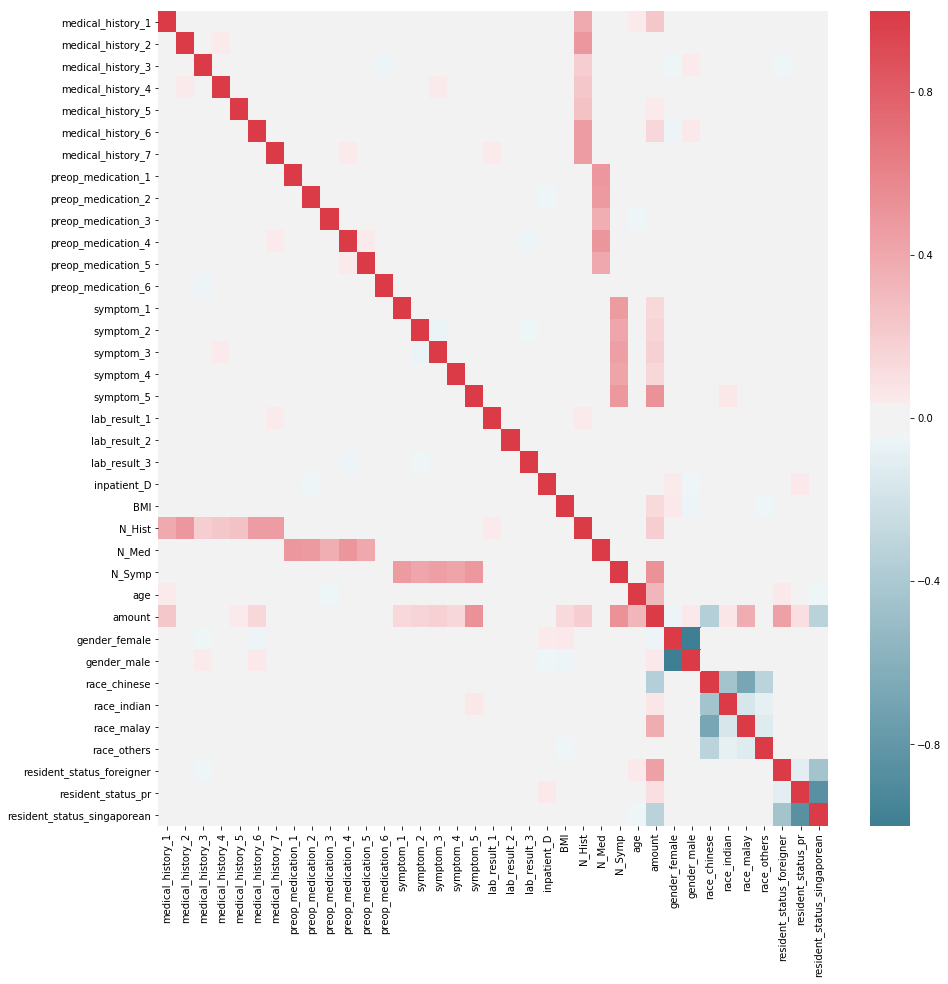

In [123]:
f, ax = plt.subplots(figsize=(15, 15))
corr = Data_encoded.corr()
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax = ax)

In [83]:
X = Data_encoded.drop('amount', axis =1)
X_ = X.as_matrix()
Y = Data_encoded.loc[:, 'amount'].astype('int64')

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [84]:
X_headers = list(X)

In [85]:
from sklearn.ensemble import ExtraTreesRegressor

et_rgr = ExtraTreesRegressor(bootstrap = True, oob_score = True)
et_rgr = et_rgr.fit(X_, Y)
etrgr_fi = et_rgr.feature_importances_
b = list(zip(X_headers,list(etrgr_fi)))
etrgr_fi_ = pd.DataFrame(data = b, columns = ['Variable', 'Feature Importance']).sort_values('Feature Importance')
etrgr_fi_.tail()

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,Variable,Feature Importance
25,N_Symp,0.073177
26,age,0.077526
31,race_malay,0.168249
33,resident_status_foreigner,0.197624
17,symptom_5,0.274006


Feature ranking:
1. symptom_5 (0.274006)
2. resident_status_foreigner (0.197624)
3. race_malay (0.168249)
4. age (0.077526)
5. N_Symp (0.073177)
6. medical_history_1 (0.049337)
7. medical_history_6 (0.020663)
8. symptom_3 (0.014332)
9. race_chinese (0.013160)
10. resident_status_singaporean (0.013026)
11. N_Hist (0.010616)
12. race_indian (0.010341)
13. resident_status_pr (0.010327)
14. BMI (0.008873)
15. symptom_2 (0.006333)
16. symptom_4 (0.004574)
17. lab_result_1 (0.004424)
18. preop_medication_1 (0.003775)
19. lab_result_2 (0.003597)
20. symptom_1 (0.003428)
21. medical_history_5 (0.003293)
22. lab_result_3 (0.002932)
23. inpatient_D (0.002852)
24. preop_medication_2 (0.002672)
25. preop_medication_4 (0.002581)
26. medical_history_7 (0.002526)
27. preop_medication_5 (0.002152)
28. medical_history_2 (0.002130)
29. N_Med (0.001939)
30. gender_female (0.001852)
31. preop_medication_6 (0.001814)
32. gender_male (0.001594)
33. preop_medication_3 (0.001446)
34. medical_history_4 (0.0013

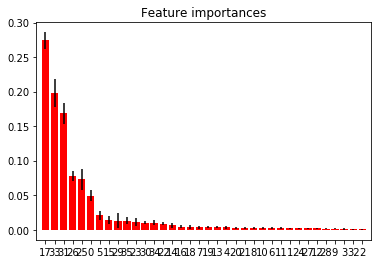

In [86]:
etrgr_fi_d = dict(zip(list(etrgr_fi), X_headers))
stdev = np.std([tree.feature_importances_ for tree in et_rgr.estimators_], axis=0)
indices = np.argsort(etrgr_fi)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_.shape[1]):
    print("%d. %s (%f)" % (f + 1, etrgr_fi_d[etrgr_fi[indices[f]]], etrgr_fi[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), etrgr_fi[indices],
       color="r", yerr=stdev[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [91]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator= ExtraTreesRegressor(), n_features_to_select =5, step=1)
rfe.fit(X_, np.asarray(Y))

c = list(zip(list(rfe.ranking_), X_headers))
pd.DataFrame.from_records(c).sort_values(by = [0]).head()

,0,1
17,1,symptom_5
33,1,resident_status_foreigner
31,1,race_malay
26,1,age
25,1,N_Symp


In [125]:
to_drop = ["preop_medication_1", "preop_medication_2", "preop_medication_3", "preop_medication_4", "preop_medication_5",
          "medical_history_2", "medical_history_3", "medical_history_4", "medical_history_5", "medical_history_7",]
Data_encoded_2 = Data_encoded.drop(to_drop, axis = 1)

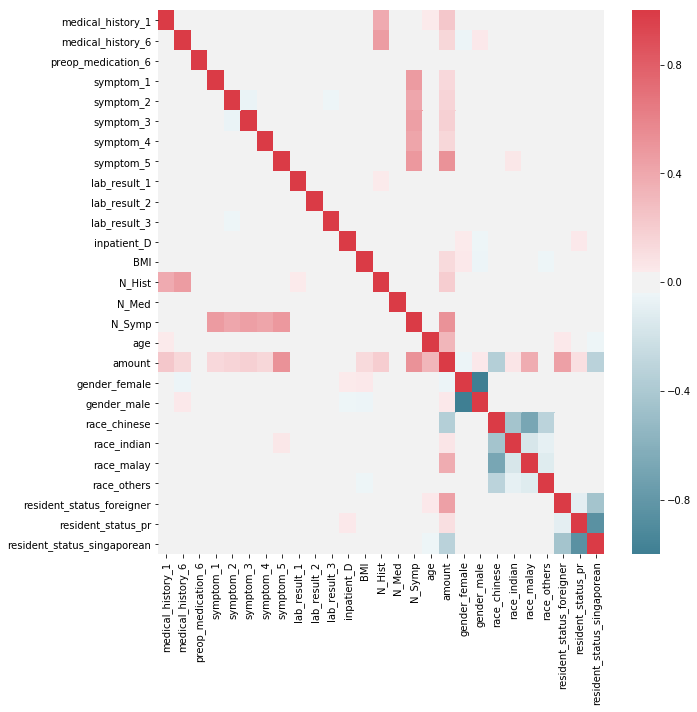

In [126]:
f, ax = plt.subplots(figsize=(10, 10))
corr_2 = Data_encoded_2.corr()
sns.heatmap(corr_2, mask=np.zeros_like(corr_2, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax = ax)

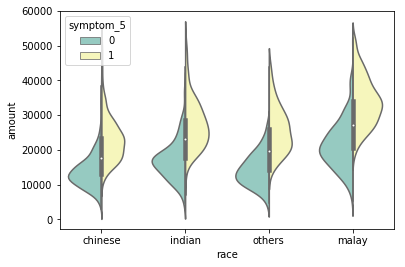

In [129]:
sns.violinplot(x="race", y="amount", hue="symptom_5", data=merged_normed,
               split=True, palette="Set3");

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  after removing the cwd from sys.path.


AttributeError: 'Axes3DSubplot' object has no attribute 'init_view'

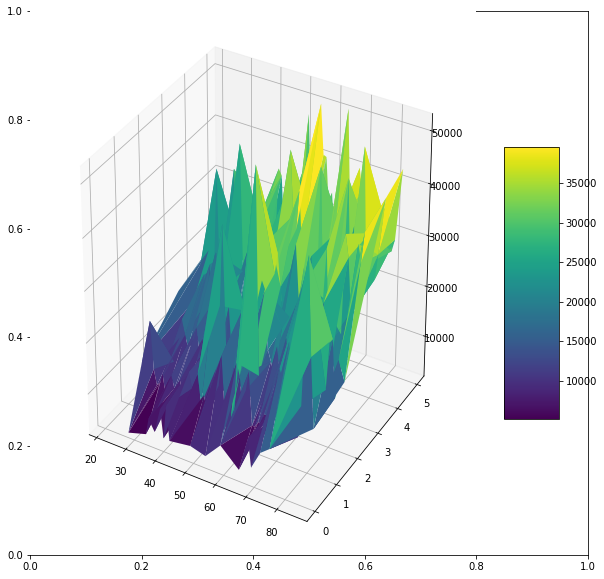

In [190]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize = (10, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(merged_normed["age"], merged_normed["N_Symp"], merged_normed["amount"], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.init_view(30,90)


In [182]:
ax.view_init(30, 45)
plt.show()

In [133]:
merged2 = joined.merge(bg_first, left_index = True, right_index = True)

In [134]:
merged2 = merged2.drop("date_of_admission_x", axis = 1)

In [146]:
merged2["Year"] = merged2.date_of_admission_y.astype('datetime64').dt.year

In [160]:
merged2.Year.value_counts()

2011    670
2012    609
2013    602
2014    573
2015    546
Name: Year, dtype: int64

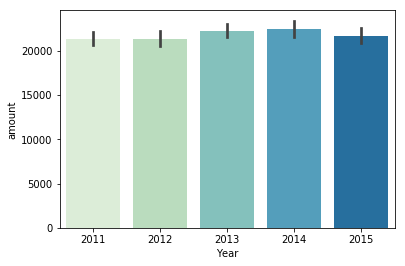

In [179]:
sns.barplot(x="Year", y="amount", data=merged2, palette="GnBu")

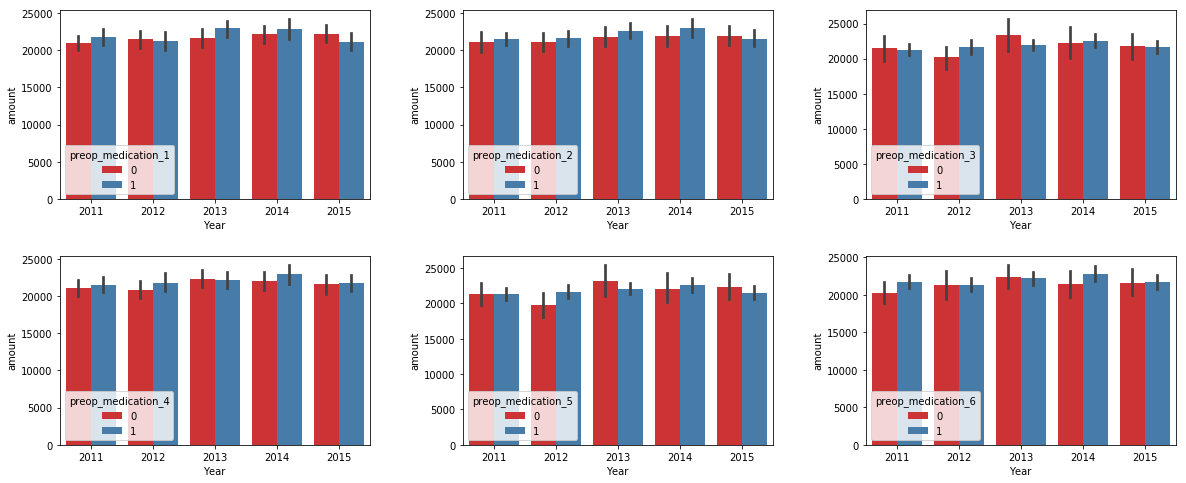

In [171]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.barplot(x="Year", y="amount", hue="preop_medication_1", data=merged2, palette="Set1", ax = ax1)
sns.barplot(x="Year", y="amount", hue="preop_medication_2", data=merged2, palette="Set1", ax = ax2)
sns.barplot(x="Year", y="amount", hue="preop_medication_3", data=merged2, palette="Set1", ax = ax3)
sns.barplot(x="Year", y="amount", hue="preop_medication_4", data=merged2, palette="Set1", ax = ax4)
sns.barplot(x="Year", y="amount", hue="preop_medication_5", data=merged2, palette="Set1", ax = ax5)
sns.barplot(x="Year", y="amount", hue="preop_medication_6", data=merged2, palette="Set1", ax = ax6)

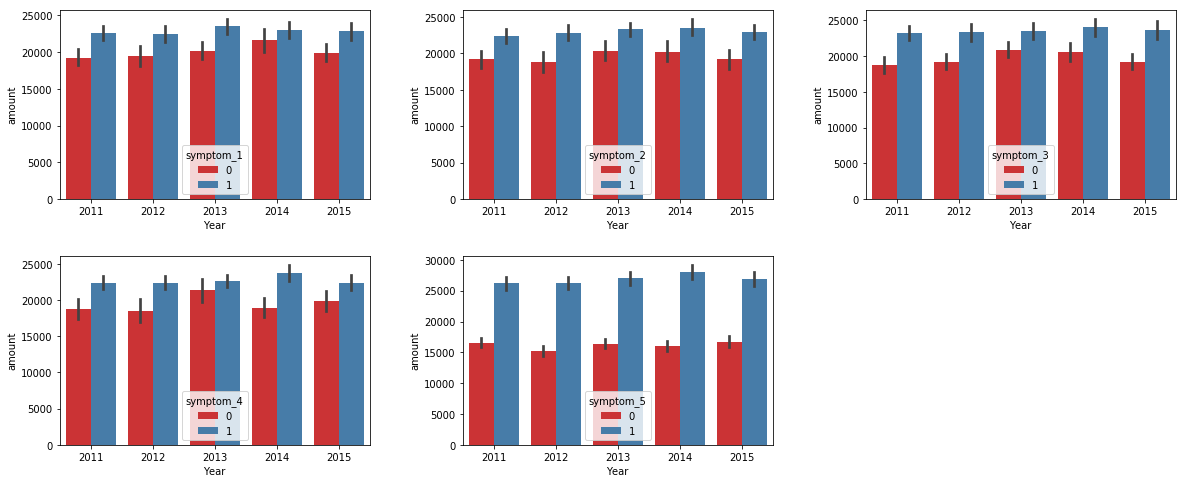

In [172]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.barplot(x="Year", y="amount", hue="symptom_1", data=merged2, palette="Set1", ax = ax1)
sns.barplot(x="Year", y="amount", hue="symptom_2", data=merged2, palette="Set1", ax = ax2)
sns.barplot(x="Year", y="amount", hue="symptom_3", data=merged2, palette="Set1", ax = ax3)
sns.barplot(x="Year", y="amount", hue="symptom_4", data=merged2, palette="Set1", ax = ax4)
sns.barplot(x="Year", y="amount", hue="symptom_5", data=merged2, palette="Set1", ax = ax5)

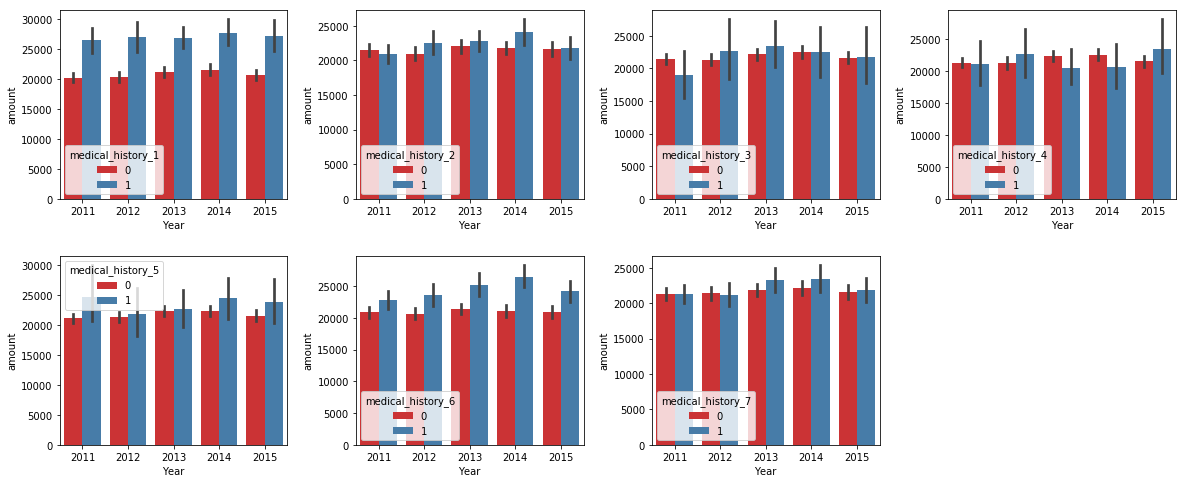

In [174]:
fig, ax = plt.subplots(figsize = (20, 8))

ax1 = plt.subplot2grid((2, 4), (0, 0))
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (0, 2))
ax4 = plt.subplot2grid((2, 4), (0, 3))
ax5 = plt.subplot2grid((2, 4), (1, 0))
ax6 = plt.subplot2grid((2, 4), (1, 1))
ax7 = plt.subplot2grid((2, 4), (1, 2))

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

sns.barplot(x="Year", y="amount", hue="medical_history_1", data=merged2, palette="Set1", ax = ax1)
sns.barplot(x="Year", y="amount", hue="medical_history_2", data=merged2, palette="Set1", ax = ax2)
sns.barplot(x="Year", y="amount", hue="medical_history_3", data=merged2, palette="Set1", ax = ax3)
sns.barplot(x="Year", y="amount", hue="medical_history_4", data=merged2, palette="Set1", ax = ax4)
sns.barplot(x="Year", y="amount", hue="medical_history_5", data=merged2, palette="Set1", ax = ax5)
sns.barplot(x="Year", y="amount", hue="medical_history_6", data=merged2, palette="Set1", ax = ax6)
sns.barplot(x="Year", y="amount", hue="medical_history_7", data=merged2, palette="Set1", ax = ax7)